In [2]:
# IMPORTS AND NOTEBOOK SETUP
from SimpleCV import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%matplotlib inline

# Config: size of the figures
matplotlib.rcParams['figure.figsize'] = [10, 6]

disp = Display(displaytype='notebook')

In [3]:
# HELPER METHODS
SIZE = 32

def get_individual_images(img):
    return [
        (int(img[0][0]), crop(img[1], 0), crop(img[2], 0)),
        (int(img[0][1]), crop(img[1], 1), crop(img[2], 1)),
        (int(img[0][2]), crop(img[1], 2), crop(img[2], 2)),
        (int(img[0][3]), crop(img[1], 3), crop(img[2], 3))
    ]

def crop(img, part):
    return img.crop(SIZE * part, 0, SIZE, SIZE)

def get_images_in_path(path):
    img_list = []
    for name in os.listdir(path):
        if name.endswith('.png'):
            img = Image(os.path.join(path, name))
            label = name[:-4]
            img_list.append((label, img))
    return img_list

In [4]:
# IMAGE PRE-PROCESSING
raw = get_images_in_path('../dataset-images/')
images = []
for img in raw:
    _bin = img[1].binarize()
    images.append((img[0], _bin.dilate().erode(), _bin))

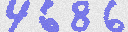

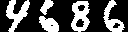

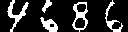

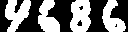

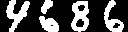

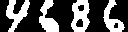

In [5]:
# EXAMPLE IMAGES
# images[0][1].save(disp)
# images[1][1].save(disp)
# images[2][1].save(disp)

img = Image('../dataset-images/4686.png')#images[0][1]
img.save(disp)
img.binarize().save(disp)
img.binarize().erode().save(disp)
img.binarize().dilate().save(disp)
img.binarize().erode().dilate().save(disp)
img.binarize().dilate().erode().save(disp)

In [6]:
# EXTRACTING INDIVIDUAL DIGITS
digits = []
for img in images:
    digits.extend(get_individual_images(img))

/usr/local/lib/python2.7/dist-packages/SimpleCV/ImageClass.py:1970: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._numpy != "":


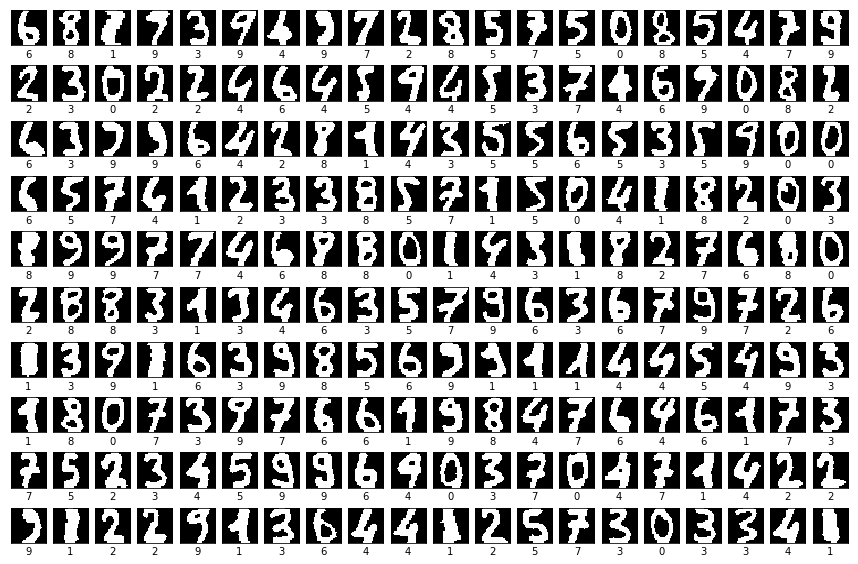

In [7]:
# PLOTTING IMAGES AND THEIR LABELS
PLOT_SIZE = 200
ROW_WIDTH = 20
plt.figure(figsize=(15, PLOT_SIZE / ROW_WIDTH))
for i in range(PLOT_SIZE):
    plt.subplot(PLOT_SIZE / ROW_WIDTH, ROW_WIDTH, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(digits[i][0])
    plt.imshow(digits[i][1].getNumpy(), cmap=plt.cm.binary)

# Save sample to an image
plt.savefig('digits_sample', dpi=200, bbox_inches='tight')

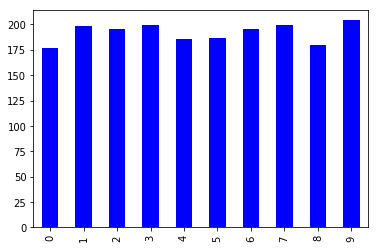

In [8]:
# CREATE DATAFRAME FROM DIGITS
columns = ['digit', 'image', 'image_raw']
data = pd.DataFrame(digits, columns=columns)
data_sorted = pd.DataFrame(sorted(digits), columns=columns)

# PLOT INTERESTING FEATURES
digit_counts = data.digit.value_counts()
digit_counts.sort_index(inplace=True)
digit_counts.plot(kind='bar')

[[  5.  32.  27.   0.]
 [ 13.  19.  33.   4.]
 [  0.  23.  39.  13.]
 [  0.  19.  32.   6.]]

[[  5.  33.  29.   0.]
 [ 13.  19.  33.   4.]
 [  0.  23.  41.  13.]
 [  0.  21.  34.   6.]]


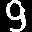

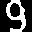

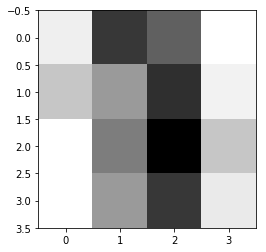

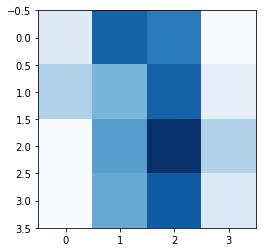

In [11]:
# TESTING WEIGHTED MATRIX CREATION
def get_weighted_matrix(img):
    COUNT = 4
    CROP = SIZE / COUNT
    m = np.zeros((COUNT, COUNT))
    for y in range(COUNT):
        for x in range(COUNT):
            part = img.crop(x * CROP, y * CROP, CROP, CROP)
            m[x][y] = (part.getNumpy()[:,:,0] / 255).sum()
    return m.T


img_raw = data_sorted.image_raw[1811]
img = data_sorted.image[1811]

m_raw = get_weighted_matrix(img_raw)
m = get_weighted_matrix(img)
print m_raw
print
print m

img_raw.save(disp)
img.save(disp)

plt.imshow(m_raw, cmap='Greys', interpolation='nearest')
plt.show()
plt.imshow(m, cmap='Blues', interpolation='nearest')
plt.show()

In [9]:
# EXTRACTING FEATURES AND SAVING TO CSV
features_dict = {
    "area": [],
    "contours": [],
    "radius": [],
    "circle_dist": [],
    "rect_dist": [],
    "hull_radius": [],
    "aspect_ratio": [],
    "centroid_x": [],
    "centroid_y": [],
    "angle": [],
    "weight_0_0": [],
    "weight_0_1": [],
    "weight_0_2": [],
    "weight_0_3": [],
    "weight_1_0": [],
    "weight_1_1": [],
    "weight_1_2": [],
    "weight_1_3": [],
    "weight_2_0": [],
    "weight_2_1": [],
    "weight_2_2": [],
    "weight_2_3": [],
    "weight_3_0": [],
    "weight_3_1": [],
    "weight_3_2": [],
    "weight_3_3": [],
    "num_holes": [],
    "label": []
}

for row in data.iterrows():
    row[1][1].show()
    blobs = row[1][1].findBlobs()
    if blobs:
        blob = blobs[0]
        features_dict['area'].append(blob.area())
        features_dict['contours'].append(len(blob.contour()))
        features_dict['circle_dist'].append(blob.circleDistance())
        features_dict['rect_dist'].append(blob.rectangleDistance())
        features_dict['radius'].append(blob.radius())
        features_dict['hull_radius'].append(blob.hullRadius())
        features_dict['aspect_ratio'].append(blob.aspectRatio())
        features_dict['centroid_x'].append(blob.centroid()[0])
        features_dict['centroid_y'].append(blob.centroid()[1])
        features_dict['angle'].append(blob.angle())

    m = get_weighted_matrix(row[1][1])
    COUNT = 4
    for x in range(COUNT):
        for y in range(COUNT):
            features_dict['_'.join(['weight', str(x), str(y)])].append(m[x, y])
    
    num_holes = len(row[1][2].embiggen(2).invert().findBlobs()[:-1])
    features_dict['num_holes'].append(num_holes)
    features_dict['label'].append(row[1][0])

# Create dataframe
data_frame = pd.DataFrame(features_dict)
# Reorder columns
data_frame = data_frame[[
    "area",
    "contours",
    "radius",
    "circle_dist",
    "rect_dist",
    "hull_radius",
    "aspect_ratio",
    "centroid_x",
    "centroid_y",
    "angle",
    "weight_0_0",
    "weight_0_1",
    "weight_0_2",
    "weight_0_3",
    "weight_1_0",
    "weight_1_1",
    "weight_1_2",
    "weight_1_3",
    "weight_2_0",
    "weight_2_1",
    "weight_2_2",
    "weight_2_3",
    "weight_3_0",
    "weight_3_1",
    "weight_3_2",
    "weight_3_3",
    "num_holes",
    "label"
]]

# Save to CSV file
data_frame.to_csv('../dataset-numpy/dataset.csv', sep=',', encoding='utf-8', index=False)

In [10]:
data_frame.describe()

,area,contours,radius,circle_dist,rect_dist,hull_radius,aspect_ratio,centroid_x,centroid_y,angle,...,weight_2_0,weight_2_1,weight_2_2,weight_2_3,weight_3_0,weight_3_1,weight_3_2,weight_3_3,num_holes,label
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,291.653385,44.952083,10.493405,0.725179,0.119105,13.664167,0.852753,15.859298,15.380416,50.857330,...,3.515104,31.285937,36.993750,6.548958,1.218229,37.840625,39.710417,6.739583,0.379688,4.532813
std,67.428881,8.744703,0.889372,0.263723,0.068749,0.814930,0.439098,1.193617,1.869070,65.489537,...,5.690358,19.265783,14.245519,6.925247,2.723832,14.236761,16.414749,9.965595,0.584767,2.868122
min,153.000000,20.000000,8.303587,0.225470,0.000000,11.549360,0.310345,11.835737,10.582800,-87.878899,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,244.000000,39.000000,9.822737,0.581376,0.063434,13.067626,0.605262,15.077516,14.116460,65.718203,...,0.000000,15.000000,28.000000,0.000000,0.000000,31.000000,33.000000,0.000000,0.000000,2.000000
50%,275.500000,44.000000,10.369215,0.687549,0.116046,13.617666,0.655172,15.797984,15.295089,85.236358,...,0.000000,32.000000,38.000000,5.000000,0.000000,40.000000,44.000000,2.000000,0.000000,5.000000
75%,326.000000,51.000000,11.043633,0.795775,0.173021,14.191667,0.724138,16.571982,16.354908,90.000000,...,6.000000,48.000000,47.000000,11.000000,1.000000,47.000000,51.000000,10.000000,1.000000,7.000000
max,512.000000,88.000000,13.117590,3.119437,0.329466,16.446964,3.171172,20.410788,20.841542,90.000000,...,39.000000,64.000000,64.000000,31.000000,29.000000,64.000000,64.000000,55.000000,2.000000,9.000000


In [11]:
data_frame.groupby(['label','num_holes']).size()

label  num_holes
0      0             12
       1            165
1      0            198
2      0            194
       1              1
3      0            199
4      0            181
       1              5
5      0            186
       1              1
6      0             47
       1            148
7      0            199
8      0             22
       1             56
       2            102
9      0             55
       1            149
dtype: int64